**EVALUATION OF FINETUNED MODELS**

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import re
from copy import copy
import tensorflow as tf
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score

Mounted at /content/drive


# Load and read and preprocess

In [ ]:
path = '/content/drive/MyDrive/results/'
predicted_model_folder = 'baseline_LaBSE/'
path_to_predicted_file = f'{predicted_model_folder}predictionsbaseline_labse_new.csv'
model_path_folder = 'my_model_v1baseline_labse_new'

# predicted_model_folder = 'baseline_distilBERT/'
# path_to_predicted_file = f'{predicted_model_folder}predictionsbaseline_distilbert.csv'
# model_path_folder = 'my_model_v1baseline_distilbert'

# ##paraphrasing
# predicted_model_folder = 'labse_oversampling_3classes/'
# path_to_predicted_file = f'{predicted_model_folder}predictionslabse_oversampling_3classes.csv'
# model_path_folder = 'my_model_v1labse_oversampling_3classes'

# ##zsl and fsl
# predicted_model_folder = 'distilbert_augmented24_gpt4/'
# path_to_predicted_file = f'{predicted_model_folder}predictionsdistilbert_augmented11.csv'
# model_path_folder = 'my_model_v1distilbert_augmented11'

# ##BT
# predicted_model_folder = 'labse_augmented35_gpt4/'
# path_to_predicted_file = f'{predicted_model_folder}predictionslabse_augmented35.csv'
# model_path_folder = 'my_model_v1labse_augmented35'

# ##oversampling
# predicted_model_folder = 'distilbert_oversampling_5classes/'
# path_to_predicted_file = f'{predicted_model_folder}predictionsdistilbert_dummy_copies_5classes.csv'
# model_path_folder = 'my_model_v1distilbert_dummy_copies_5classes'


In [ ]:
# from google.colab import files
# files.download(f'{path}test.tsv')

In [ ]:
test_df = pd.read_csv(f'{path}test.tsv', sep='\t', header=None)
print(len(test_df))

5427


In [ ]:
##Load saved model
# loaded_model = load_model(f'{path}/my_model_v1baseline.h5', compile = False)

In [ ]:
# Load file 'emotions.txt'
with open(f'{path}emotions.txt','r') as file:
  emotions = [line.strip() for line in file.readlines()]

In [ ]:
# # Load the file 'predictionsbaseline.txt'
# with open(f'{path}/predictions.txt', 'r') as file:
#     prd = file.read()
# lists = re.findall(r'\[(.*?)\]', prd, re.DOTALL)

# predictions = []

# for lst in lists:
#     float_elements = [float(e) for e in lst.split() if e]
#     predictions.append(float_elements)

# predictions_array = np.array(predictions)

In [ ]:
## Load prediction arrays
file_path = f'{path}/{path_to_predicted_file}'

df = pd.read_csv(file_path, header=None)

# Convert the DataFrame to a NumPy array
predictions_array = df.to_numpy()
predictions_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
##check if multi-label
multi_label_rows = [row for row in predictions_array if np.sum(row) > 1]

if multi_label_rows:
    print("The predictions are multi-label for the following rows:")
    for row in multi_label_rows:
        print(row)
        break
else:
    print("The predictions are single-label.")

print(f'Number of elements that were predicted as multi-label: {len(multi_label_rows)}')

The predictions are multi-label for the following rows:
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Number of elements that were predicted as multi-label: 213


In [ ]:
## Let's recreate test_labels (ground truth) for evaluating results

# Transform the labels
def convert_to_vec(el,num=28):
  lst = [0.0 for _ in range(num)]
  for num in el:
    lst[int(num)] =1
  return lst

test_X_df, test_labels_df = test_df[0], test_df[1]

test_labs = []
for el in test_labels_df.values:
    n_l = []
    l = re.split(',', el)
    for e in l:
        n_l.append(np.float64(e))
    test_labs.append(copy(convert_to_vec(n_l)))
test_labs = np.asarray(test_labs).astype(np.float32)

##check prediction equal test labs (ground truth)
print("Is PREDICTED length equal to GROUND TRUTH? ----->",len(predictions_array) == len(test_labs))


Is PREDICTED length equal to GROUND TRUTH? -----> True


#Make prediction one more time to get prediction probabilites

In [ ]:
!pip install ktrain transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 23.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 65.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 40.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.41.2-py3-none-any.whl size=25317058 sha256=749d6bd91752d9f10ca503c2ad67a81d319a91c180c652387e64dc5d45631e4a
  Stored in directory: /root/.cache/pip/wheels/35/7e/6e/0a327a2a8202d

In [ ]:
import ktrain
from transformers import TFAutoModelForSequenceClassification
from ktrain import text as ktext


In [ ]:
test_X_df,test_labels_df = test_df[0],test_df[1]

In [ ]:
def convert_to_vec(el,num=28):
  lst = [0.0 for _ in range(num)]
  for num in el:
    lst[int(num)] =1
  return lst


test_labs = []
for el in test_labels_df.values:
  n_l = []
  l = re.split(',',el)
  for e in l:
    n_l.append(np.float64(e))
  test_labs.append(copy(convert_to_vec(n_l)))
test_labs = np.asarray(test_labs).astype(np.float32)

In [ ]:
# test_labs

##I aproach

In [ ]:
#load model
model_path = f'{path}{predicted_model_folder}{model_path_folder}'
model = TFAutoModelForSequenceClassification.from_pretrained(model_path)

In [ ]:
##preprocessing test data
# MODEL_NAME = "distilbert-base-uncased"
MODEL_NAME = "sentence-transformers/LaBSE"
t = ktext.Transformer(MODEL_NAME, maxlen=124, class_names=emotions)

test = t.preprocess_test(list(test_X_df), test_labs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/ktrain/text/preprocessor.py:392: UserWarning: The method preprocess_train was never called. You can disable this warning by setting preprocess_train_called=True.
  warnings.warn(


preprocessing test...
language: None
test sequence lengths:
	mean : 13
	95percentile : 24
	99percentile : 27


tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
input_ids = [sample[0][0][0] for sample in test]
attention_mask = [sample[0][0][1] for sample in test]
labels = [sample[1][0] for sample in test]

input_ids = tf.convert_to_tensor(input_ids)
attention_mask = tf.convert_to_tensor(attention_mask)
labels = tf.convert_to_tensor(labels)

In [ ]:
prediction_inputs = {
    'input_ids': input_ids,
    'attention_mask': attention_mask
}

In [ ]:
predictions = model.predict(prediction_inputs)

170/170 [==============================] - 1133s 7s/step


In [ ]:
predictions

TFSequenceClassifierOutput(loss=None, logits=array([[-3.2823887 , -5.0927505 , -5.0522747 , ..., -0.10554497,
        -5.989921  , -4.8133526 ],
       [ 2.7804275 , -5.710328  , -5.2854524 , ..., -4.561794  ,
        -5.5412655 , -4.990021  ],
       [-0.9621243 , -4.973406  , -6.160503  , ..., -6.757634  ,
        -5.1710343 , -3.8853133 ],
       ...,
       [-6.6463304 , -6.212509  , -5.1724277 , ..., -4.8749843 ,
        -7.5551248 ,  1.711485  ],
       [-0.59769636, -5.5197916 , -7.475754  , ..., -5.2111754 ,
        -5.8353243 , -4.2494335 ],
       [-5.0228953 , -4.5095835 , -6.0347943 , ..., -6.382323  ,
        -4.6458254 ,  2.3685808 ]], dtype=float32), hidden_states=None, attentions=None)

In [ ]:
probabilities = tf.nn.softmax(predictions.logits, axis=-1)

In [ ]:
probabilities[5426]

<tf.Tensor: shape=(28,), dtype=float32, numpy=
array([6.08368020e-04, 1.01647084e-03, 2.21158698e-04, 8.61688284e-04,
       1.79547584e-03, 5.94009434e-05, 1.29641790e-04, 1.35563430e-04,
       2.05162549e-04, 3.86617234e-04, 1.98256908e-04, 1.50443913e-04,
       1.23030914e-04, 1.67555013e-03, 4.82673495e-05, 5.36326625e-05,
       4.85660894e-05, 2.02683103e-03, 1.08217246e-04, 5.72782374e-05,
       1.95261426e-04, 2.88716692e-04, 1.56079733e-03, 1.43063124e-04,
       2.62213125e-05, 1.56233567e-04, 8.87004368e-04, 9.86833036e-01],
      dtype=float32)>

In [ ]:
# #evaluation
# from sklearn.metrics import f1_score

# Convert probabilities to binary predictions (you may choose a threshold other than 0.5)
threshold = 0.5

binary_predictions = tf.cast(probabilities > threshold, tf.int32)

# Calculate F1 Score
f1 = f1_score(labels, binary_predictions, average='macro')  # or 'macro' based on your requirement
print(f"F1 Score: {f1}")

F1 Score: 0.44315453508983954


##II aproach with preproc

In [ ]:
# model_path_folder2='my_model_v1_with_preprocesorlabse_augmented3'
# new_model_path = f'{path}{predicted_model_folder}{model_path_folder2}'

# import os
# for file in os.listdir(new_model_path):
#     print(file)



In [ ]:
# #load model and preproc
# predictor = ktrain.load_predictor(new_model_path)

In [ ]:
# prediction = predictor.predict(list(test_X_df))

# Evaluate quality of model

In [ ]:
# Overall Accuracy
overall_accuracy = accuracy_score(test_labs, binary_predictions)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# Overall Macro and Micro F1 Scores
macro_f1 = f1_score(test_labs, binary_predictions, average='macro')
micro_f1 = f1_score(test_labs, binary_predictions, average='micro')
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Micro F1 Score: {micro_f1:.4f}")

# ##Precision, Recall, and F1-score

precision_macro = precision_score(test_labs, binary_predictions, average='macro')
recall_macro = recall_score(test_labs, binary_predictions, average='macro')
f1_macro= f1_score(test_labs, binary_predictions, average='macro')
print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1 Score: {f1_macro:.4f}")

print("")

precision_micro = precision_score(test_labs, binary_predictions, average='micro')
recall_micro = recall_score(test_labs, binary_predictions, average='micro')
f1_micro = f1_score(test_labs, binary_predictions, average='micro')
print(f"Micro Precision: {precision_micro:.4f}")
print(f"Micro Recall: {recall_micro:.4f}")
print(f"Micro F1 Score: {f1_micro:.4f}")

Overall Accuracy: 0.4649
Macro F1 Score: 0.4432
Micro F1 Score: 0.5698
Macro Precision: 0.5991
Macro Recall: 0.3722
Macro F1 Score: 0.4432

Micro Precision: 0.7035
Micro Recall: 0.4787
Micro F1 Score: 0.5698


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# ##Hamming Loss
from sklearn.metrics import hamming_loss

hamming = hamming_loss(test_labs, binary_predictions)
print(f"Hamming Loss: {hamming:.4f}")


Hamming Loss: 0.0301


In [ ]:
##Confusion Matrix
from sklearn.metrics import multilabel_confusion_matrix

cm = multilabel_confusion_matrix(test_labs, binary_predictions)

In [ ]:
#get tn,fp,fn,tp for each class
tn_list = []
fp_list = []
fn_list = []
tp_list = []

for i in range(28):
    tn, fp, fn, tp = cm[i].ravel()
    tn_list.append(tn)
    fp_list.append(fp)
    fn_list.append(fn)
    tp_list.append(tp)

In [ ]:
class_counts_test = np.sum(test_labs, axis=0)
class_counts_pred = np.sum(binary_predictions, axis=0)

for idx, (name, count_test, count_pred) in enumerate(zip(emotions, class_counts_test, class_counts_pred)):
    print(f"{name}: {count_test} ground truth, {count_pred} predictions")

admiration: 504.0 ground truth, 488 predictions
amusement: 264.0 ground truth, 231 predictions
anger: 198.0 ground truth, 115 predictions
annoyance: 320.0 ground truth, 99 predictions
approval: 351.0 ground truth, 132 predictions
caring: 135.0 ground truth, 80 predictions
confusion: 153.0 ground truth, 93 predictions
curiosity: 284.0 ground truth, 117 predictions
desire: 83.0 ground truth, 49 predictions
disappointment: 151.0 ground truth, 52 predictions
disapproval: 267.0 ground truth, 140 predictions
disgust: 123.0 ground truth, 63 predictions
embarrassment: 37.0 ground truth, 17 predictions
excitement: 103.0 ground truth, 43 predictions
fear: 78.0 ground truth, 57 predictions
gratitude: 352.0 ground truth, 328 predictions
grief: 6.0 ground truth, 0 predictions
joy: 161.0 ground truth, 114 predictions
love: 238.0 ground truth, 232 predictions
nervousness: 23.0 ground truth, 19 predictions
optimism: 186.0 ground truth, 110 predictions
pride: 16.0 ground truth, 2 predictions
realizatio

In [ ]:
# Convert multi-label to multi-class --> this is potentially wrong becouse it disregards fact of multi-label instances
# true_classes = test_labs.argmax(axis=1)
# predicted_classes = predictions_array.argmax(axis=1)



# ths = 0.5
# predicted_classes = (predictions_array >= ths).astype(int)
true_classes = test_labs
report = classification_report(true_classes, binary_predictions, target_names=emotions, zero_division=0)

print(report)

                precision    recall  f1-score   support

    admiration       0.69      0.67      0.68       504
     amusement       0.81      0.71      0.76       264
         anger       0.62      0.36      0.45       198
     annoyance       0.53      0.16      0.25       320
      approval       0.58      0.22      0.31       351
        caring       0.57      0.34      0.43       135
     confusion       0.54      0.33      0.41       153
     curiosity       0.55      0.23      0.32       284
        desire       0.63      0.37      0.47        83
disappointment       0.50      0.17      0.26       151
   disapproval       0.49      0.26      0.34       267
       disgust       0.60      0.31      0.41       123
 embarrassment       0.82      0.38      0.52        37
    excitement       0.63      0.26      0.37       103
          fear       0.77      0.56      0.65        78
     gratitude       0.96      0.90      0.93       352
         grief       0.00      0.00      0.00  

In [ ]:
## calculate f1-macro for this augmented classes
report_dict = classification_report(true_classes, binary_predictions, target_names=emotions, zero_division=0, output_dict=True)

aug_clss = ['embarrassment','grief','nervousness','pride','relief']
f1_aug_cls_scores = []

for cls in aug_clss:
  f1_aug_cls_score = report_dict[cls]['f1-score']
  f1_aug_cls_scores.append(f1_aug_cls_score)

average_f1_aug_cls = sum(f1_aug_cls_scores)/len(f1_aug_cls_scores)
print(f"Average F1-Score for augmented classes: {average_f1_aug_cls}")


Average F1-Score for augmented classes: 0.20211640211640214


# Plot and save results

##**RESULTS**

In [ ]:
# model_experiment_name = f'modelX_experimentX'

In [ ]:
##save results to csv

#save cm
flatten_cm = cm.reshape(len(emotions),4)
cm_df = pd.DataFrame(flatten_cm, index=emotions,columns=['True Negative', 'False Positive', 'False Negative', 'True Positive'])
cm_df.to_csv(f'{path}{predicted_model_folder}performance_results/confusion_matrix.csv')

#save report
report = classification_report(true_classes, binary_predictions, target_names=emotions, zero_division=0, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(4)
report_df.to_csv(f'{path}{predicted_model_folder}performance_results/classification_report.csv')

#save rest results
results =  {
"Metric": ["Number of Test Instances", "Hamming Loss", "F1 Macro", "F1 Micro", "Average F1 Augmented Classes"],
"Value": [len(test_df), hamming, f1_macro, f1_micro, average_f1_aug_cls]
}
results_df = pd.DataFrame(results)
results_df = results_df.round(4)
results_df.to_csv(f'{path}{predicted_model_folder}performance_results/performance_results.csv', index=False)

##**PLOTS**

###Heatmap for CM

In [ ]:
#HeatMaps for CM each label
for i, c in enumerate(cm):
    cm_df = pd.DataFrame(c, index=['True Negative', 'True Positive'],
                             columns=['Predicted Negative', 'Predicted Positive'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap='Reds')
    plt.title(f'Confusion Matrix for {emotions[i]}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'{path}{predicted_model_folder}performance_results/plots/cm/confusion_matrix_{emotions[i]}.png')

    plt.clf()
    plt.close()

###PR curve

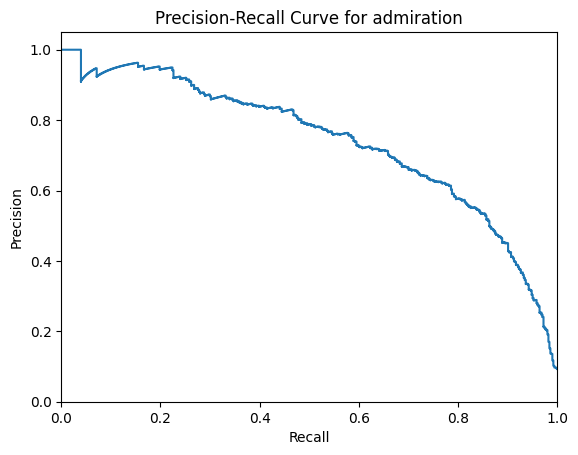

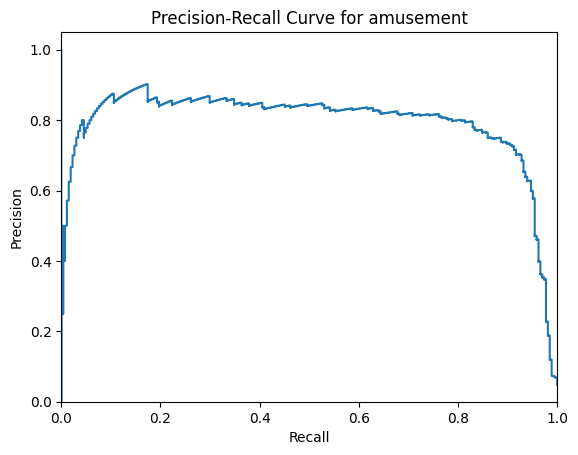

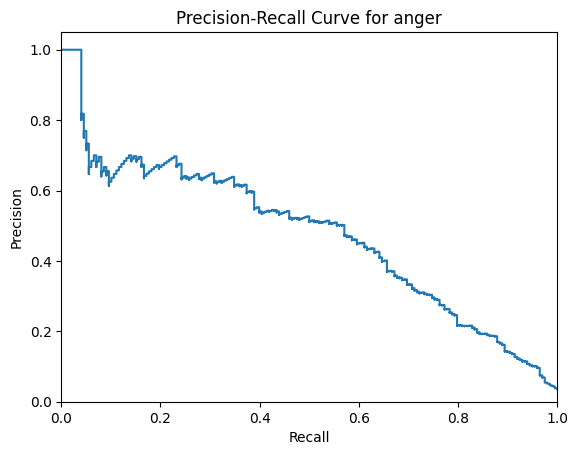

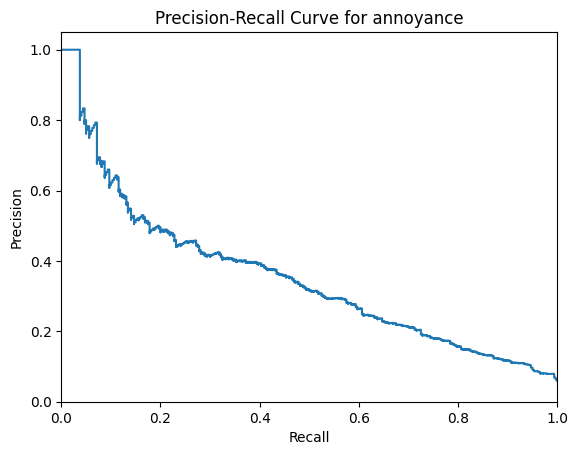

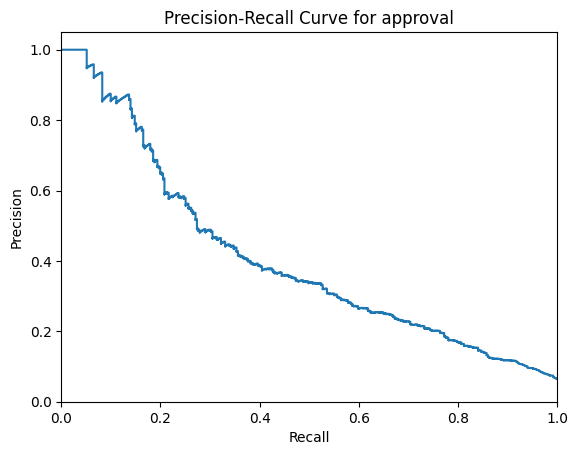

KeyboardInterrupt: 

In [ ]:
## PR curve for each label

probabilities_np = probabilities.numpy()
labels_np = labels.numpy()

for i, emotion in enumerate(emotions):
    precision, recall, threshold = precision_recall_curve(labels_np[:, i], probabilities_np[:, i])
    plt.figure()
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curve for {emotions[i]}')
    # plt.savefig(f'{path}{predicted_model_folder}performance_results/plots/PR_curve/PR_curve_{emotions[i]}.png')
    # plt.clf()
    # plt.close()
    plt.show()

In [ ]:
## PR curve -- for all
plt.figure(figsize=(10, 8))

for i, emotion in enumerate(emotions):
    precision, recall, threshold = precision_recall_curve(labels_np[:, i], probabilities_np[:, i])
    plt.step(recall, precision, where='post', label=f'{emotion}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for All Labels')
plt.legend(loc="upper right")
# plt.savefig(f'{path}{predicted_model_folder}performance_results/plots/PR_curve/PR_Curves_All.png')
plt.clf()
plt.close()

In [ ]:
## PR curve -- for 5 aug classes
aug_classes=['embarrassment', 'grief', 'nervousness','pride','relief',]
plt.figure(figsize=(10, 8))  # Create a larger figure for clarity

for emotion in aug_classes:
    if emotion in emotions:
        i = emotions.index(emotion)
        precision, recall, threshold = precision_recall_curve(labels_np[:, i], probabilities_np[:, i])
        plt.step(recall, precision, where='post', label=f'{emotion}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for Selected Labels')
plt.legend(loc="upper right")
# plt.savefig(f'{path}{predicted_model_folder}performance_results/plots/PR_curve/PR_Curves_Selected.png')
plt.clf()
plt.close()
# plt.show()

###ROC AUC curve

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

#ROC curve and AUC -- for each label
for i in range(28):
    # fpr[i], tpr[i], _ = roc_curve(true_classes[:, i], predictions_array[:, i])
    # roc_auc[i] = auc(fpr[i], tpr[i])
    fpr, tpr, _ = roc_curve(true_classes[:, i], probabilities[:, i])

    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkred', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='darkblue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    plt.title(f'ROC Curve for {emotions[i]}')
    plt.legend(loc="lower right")
    plt.fill_between(fpr, tpr, color='burlywood', alpha=0.2)
    # plt.show()
    plt.savefig(f'{path}{predicted_model_folder}performance_results/plots/ROC_curve_AUC/ROC_AUC_{emotions[i]}.png')
    plt.clf()
    plt.close()


In [ ]:
from matplotlib import cm
#ROC curve and AUC -- for all

auc_colormaps = {
    'excellent': (cm.Reds, 0.94, 1.0),
    'good': (cm.Blues, 0.92, 0.94),
    'fair': (cm.Greens, 0.85, 0.92),
    'poor': (cm.copper, 0.5, 0.85)
}

def get_color(auc_value):
    for colormap, range_start, range_end in auc_colormaps.values():
        if range_start <= auc_value <= range_end:
            gradient_index = (auc_value - range_start) / (range_end - range_start)
            return colormap(gradient_index)

plt.figure(figsize=(16, 8))

for i in range(28):
    fpr, tpr, _ = roc_curve(true_classes[:, i], probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    color = get_color(roc_auc)

    for j in range(len(fpr) - 1):
        plt.plot(fpr[j:j+2], tpr[j:j+2], color=color, lw=2)

    plt.plot(fpr[-2:], tpr[-2:], color=color, lw=2, label=f'{emotions[i]} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC Curves for All Emotions')
plt.legend(loc="upper right")
plt.savefig(f'{path}{predicted_model_folder}performance_results/plots/ROC_curve_AUC/ROC_AUC_all.png')
plt.clf()
plt.close()

In [ ]:
#ROC curve and AUC -- for 5 augmented label
aug_classes=['embarrassment', 'grief', 'nervousness','pride','relief',]
aug_classes_list= [emotions.index(emotion) for emotion in aug_classes if emotion in emotions]
plt.figure(figsize=(16, 8))

for i in aug_classes_list:
  fpr, tpr, _ = roc_curve(true_classes[:, i], probabilities[:, i])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, lw=2, label=f'{emotions[i]} (area = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('ROC Curves for Aug Emotions')
plt.legend(loc="upper right")

# plt.show()
plt.savefig(f'{path}{predicted_model_folder}performance_results/plots/ROC_curve_AUC/ROC_AUC_5augcls.png')
plt.clf()
plt.close()

###F1 by label plots

In [ ]:
##F1 Score by Label bar chart
report = classification_report(true_classes, binary_predictions, target_names=emotions, output_dict=True, zero_division=0)
f1_all_cls = [report[emotion]['f1-score'] for emotion in emotions]

# Plotting
plt.figure(figsize=(14,10))
plt.bar(emotions, f1_all_cls, color='darkred')
plt.xlabel('Emotions')
plt.ylabel('F1 Score')
plt.title('F1 Scores by Label')
plt.xticks(rotation=90)
plt.ylim([0, 1])
plt.savefig(f'{path}{predicted_model_folder}performance_results/plots/f1_all_barchart.png')
plt.clf()
plt.close()

###Density prob. plot

In [ ]:
##density plots of prob for each class

for i in range(28):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(probabilities[:, i], fill=True)
    plt.title(f'Density Plot of Predictions for {emotions[i]}')
    plt.xlabel('Prediction Probability')
    plt.ylabel('Density')
    plt.legend(loc="upper right")
    plt.savefig(f'{path}/{predicted_model_folder}performance_results/plots/density_plots/density_plot{emotions[i]}.png')
    plt.clf()
    plt.close()

# Plotting density plots for all classes on the same plot
plt.figure(figsize=(10, 6))

for i in range(probabilities.shape[1]):
    sns.kdeplot(probabilities[:, i], label=emotions[i])

plt.title('Density Plot of Predictions for All Labels')
plt.xlabel('Prediction Probability')
plt.ylabel('Density')
plt.legend(title='Emotions',loc="upper right")
plt.savefig(f'{path}{predicted_model_folder}performance_results/plots/density_plots/density_plot_all.png')
plt.clf()
plt.close()


##density plot for 5 aug cls
aug_classes=['embarrassment', 'grief', 'nervousness','pride','relief',]
cls_map = [emotions.index(cls) for cls in aug_classes]
plt.figure(figsize=(10, 6))
for i in cls_map:
      sns.kdeplot(probabilities[:, i], label=emotions[i], fill=True)
plt.title('Density Plot of Predictions for Selected Emotions')
plt.xlabel('Prediction Probability')
plt.ylabel('Density')
plt.xlim(-0.1, 0.1)
plt.legend(loc="upper right")
plt.savefig(f'{path}{predicted_model_folder}performance_results/plots/density_plots/density_plot_5AugCls.png')
plt.clf()
plt.close()


###Label frequency distribution plots

In [ ]:
import os
len_train_before = None
# ##Label frequency distribution -- in training dataset and in numbers of predicted in each class
train_file_path = f'{path}/{predicted_model_folder}/train.tsv'
training_dataset_file_path = f'{path}{predicted_model_folder}/training_dataset.tsv'
train = pd.read_csv(train_file_path, sep='\t', header=None)

if os.path.exists(training_dataset_file_path):
    training_dataset = pd.read_csv(training_dataset_file_path, sep='\t', header=None)
    len_train_before = len(training_dataset)
    training_dataset = pd.concat([train, training_dataset], ignore_index=True)
else:
    training_dataset = train

len_train_after = len(training_dataset)

with open(f'{path}{predicted_model_folder}performance_results/length.txt', 'w') as file:
  file.write(f'Length of enhancing data: {len_train_before}\n')
  file.write(f'Length of train dataset after enhancing: {len_train_after}\n')


train_X_df, train_labels_df = training_dataset[0], training_dataset[1]
single_labels_df = train_labels_df[train_labels_df.apply(lambda x: str(x).isdigit())]
single_labels_df = single_labels_df.astype(int)
class_distribution = single_labels_df.value_counts()
class_distribution = class_distribution[class_distribution.index != 27].sort_index()
print(class_distribution.sort_index())

emotion_names = emotions[:-1]

plt.figure(figsize=(16, 12))
class_distribution.plot(kind='bar', color='darkred')
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.xticks(ticks=range(len(emotion_names)), labels=emotion_names, rotation=90)
plt.grid(axis='y')
plt.savefig(f'{path}{predicted_model_folder}performance_results/plots/class_distribution.png')
plt.clf()
plt.close()


0     2710
1     1652
2     1025
3     1451
4     1873
5      649
6      858
7     1389
8      389
9      709
10    1402
11     498
12     203
13     510
14     430
15    1857
16    1039
17     853
18    1427
19      85
20     861
21    2051
22     586
23    3088
24     353
25     817
26     720
Name: 1, dtype: int64


###Plot count predicted vs test

In [ ]:
## number in test set each label vs number of predicted each label -- grouped bar cha
##withou neutral as it has many instances and doesnt need for analysis

fig, ax = plt.subplots(figsize=(20, 12))

index = np.arange(len(emotions[:-1]))
bar_width = 0.4

bar1 = ax.bar(index, class_counts_test[:-1], bar_width, label='Test Set', color = "blue", edgecolor = "black")
bar2 = ax.bar(index + bar_width, class_counts_pred[:-1], bar_width, label='Predictions',color = "red",
       edgecolor = "black")

ax.set_xlabel('Emotions')
ax.set_ylabel('Counts')
ax.set_title('Counts by Emotion and Set')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(emotions[:-1],rotation = 90)
ax.legend()
plt.savefig(f'{path}{predicted_model_folder}performance_results/plots/count_test_pred.png')
plt.clf()
plt.close()